In [1]:
import pandas
from davitpy.models import *
from davitpy import utils
from davitpy import pydarn
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

In [2]:
selDT = datetime.datetime.utcnow()

In [3]:
colNames = [ "name", "code", "glat", "glon", "ins", "model", "status", "RT_status", "data_avail" ]
chainLocDF = pandas.read_csv("../data/chain-stations.txt", delim_whitespace=True,\
                                    header=None, names=colNames)
# get MLAT and MLON
gLonArr = chainLocDF["glon"].values
gLatArr = chainLocDF["glat"].values
mlon, mlat = utils.coord_conv( gLonArr, gLatArr, \
                                 "geo", "mag", altitude=300., \
                                 date_time=selDT )
chainLocDF["mlon"] = mlon
chainLocDF["mlat"] = mlat
selStnDF = chainLocDF[ chainLocDF["mlat"] <= 70. ].reset_index(drop=True)
selStnDF.head(10)

,name,code,glat,glon,ins,model,status,RT_status,data_avail,mlon,mlat
0,Churchill,chu,58.759279,265.913402,GISTM/GPS,PolaRxS,Active,Complete,Near-Real-time,-27.133506,69.014797
1,Fort-McMurray,mcm,56.649535,248.779728,GISTM/GPS,PolaRxS,Active,Complete,Near-Real-time,-51.328552,64.857081
2,Fort-Simpson,fsi,61.756554,238.771946,GISTM/GPS,PolaRxS,Active,Complete,Near-Real-time,-66.269408,67.848076
3,Fort-Smith,fsm,60.026095,248.067109,GISTM/GPS,PolaRxS,Active,Complete,Near-Real-time,-53.664781,67.917797
4,Gillam,gil,56.376600,265.356197,GISTM/GPS,PolaRxS,Active,Complete,Near-Real-time,-27.561448,66.775032
5,Ministik-Lake,edm,53.350818,247.026160,GISTM/GPS,PolaRxS,Active,Complete,Near-Real-time,-52.458750,61.394155
6,Rabbit-Lake,rab,58.226935,256.322945,GISTM/GPS,PolaRxS,Active,Complete,Near-Real-time,-41.491425,67.513914
7,Sanikiluaq,san,56.536360,280.768771,GISTM/GPS,GSV4004B,Active,Complete,Near-Real-time,-3.498554,67.111440


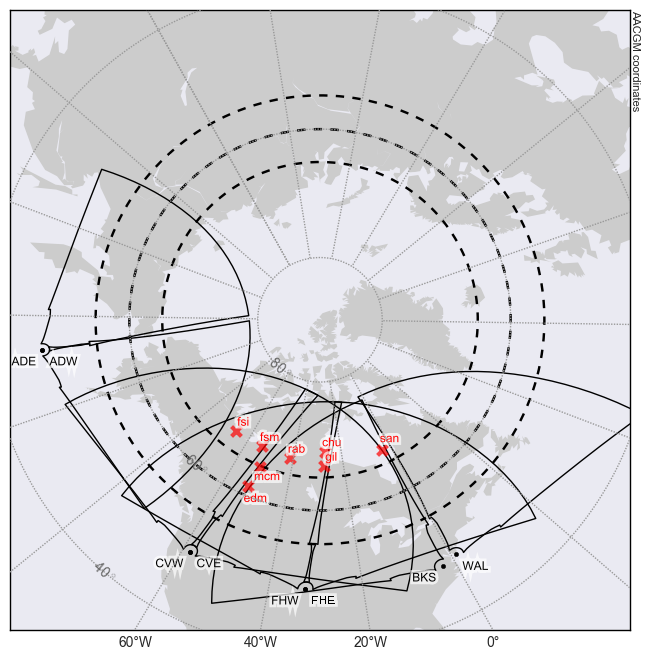

In [4]:
# Plot map
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=40., gridLabels=True, coords='mag', ax=ax, datetime=selDT)

for index, row in selStnDF.iterrows():
    xVecGpsStn, yVecGpsStn = m1(row["mlon"], row["mlat"], coords="mag")
    m1.scatter( xVecGpsStn, yVecGpsStn, s=50., color="r", \
           alpha=0.7, zorder=5., edgecolor='none', marker="x", linewidth='3' )
    if row["mlat"] > 65.:
        yoff = 10
    else:
        yoff = -5
    utils.plotUtils.textHighlighted((xVecGpsStn, yVecGpsStn), row["code"], ax=ax,
                    xytext=(5, yoff), text_alignment=(0.5, 1),
                    variant='small-caps', fontsize=12,
                    zorder=6, color="r")
codes = ['wal','fhe','fhw','cve','cvw','ade','adw','bks']
for i,rad in enumerate(codes):
    # Plot radar
    pydarn.plotting.overlayRadar(m1, fontSize=12, codes=rad)
    # Plot radar fov
    pydarn.plotting.overlayFov(m1, codes=rad, maxGate=70)
markLats = [ 55., 60., 65. ]    
for currLat in markLats:
    latList = [ currLat for i in range(0,360) ]
    lonList = [ i for i in range(0,360) ]
    xVecGpsStn, yVecGpsStn = m1(lonList, latList, coords="mag")
    m1.plot( xVecGpsStn, yVecGpsStn, "k--" )
# pydarn.plotting.overlayFov(m1, codes=codes[:-1], maxGate=70)#, fovColor=(.8,.9,.9))
# pydarn.plotting.overlayFov(m1, codes=codes[-1], maxGate=70, fovColor=(.8,.7,.8), fovAlpha=.5)
f.savefig("../figs/chain-stations.pdf",bbox_inches='tight')

In [5]:
def convert_to_datetime(row, datecolName="dateStr", timeColName="time"):
    currDateStr = str( int( row[datecolName] ) )
#     return currDateStr
    if row[timeColName] < 10:
        currTimeStr = "000" + str( int( row[timeColName] ) )
    elif row[timeColName] < 100:
        currTimeStr = "00" + str( int( row[timeColName] ) )
    elif row[timeColName] < 1000:
        currTimeStr = "0" + str( int( row[timeColName] ) )
    else:
        currTimeStr = str( int( row[timeColName] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )

# Find SAPS events with scintillations data
datFileName = "../data/processedSaps-new.txt"
sapsDataDF = pandas.read_csv(datFileName, sep=' ')
# add dst_bins
dstBins = [ -150, -75, -50, -25, -10, 10 ]
sapsDataDF = pandas.concat( [ sapsDataDF, \
                    pandas.cut( sapsDataDF["dst_index"], \
                               bins=dstBins ) ], axis=1 )
sapsDataDF.columns = [ ["dateStr", "hour","sapsLat", \
                     "sapsMLT", "sapsVel", "radId", "poesLat",\
                     "poesMLT", "dst_date", "dst_index", "time", "dst_bin"] ]
sapsDataDF = sapsDataDF.drop(["radId", "poesLat", "poesMLT", "dst_date", "hour"], 1)
sapsDataDF["dtObj"] = sapsDataDF.apply( convert_to_datetime, axis=1 )
sapsDataDF.head()

,dateStr,sapsLat,sapsMLT,sapsVel,dst_index,time,dst_bin,dtObj
0,20110107,56.5,17.7543,308.2077,-18,0,"(-25, -10]",2011-01-07
1,20110107,55.5,18.0147,224.1588,-18,0,"(-25, -10]",2011-01-07
2,20110107,56.5,17.8749,307.4328,-18,0,"(-25, -10]",2011-01-07
3,20110107,55.5,18.1324,222.4787,-18,0,"(-25, -10]",2011-01-07
4,20110107,56.5,17.9955,305.4201,-18,0,"(-25, -10]",2011-01-07


In [6]:
chainDataDF = selStnDF[ [ "name", "code", "mlat", "mlon" ] ]
chainDataDF.columns = [ "stnName", "stnCode", "stnMlat", "stnMlon" ]
for index, row in chainDataDF.iterrows():
    currStnName = row["stnCode"]
    sapsDataDF[currStnName + "_mlat"] = abs( sapsDataDF["sapsLat"] - row["stnMlat"] )
    sapsDataDF[currStnName + "_mlon"] = row["stnMlon"]

chu_mlt_arr = []
mcm_mlt_arr = []
fsi_mlt_arr = []
gil_mlt_arr = []
edm_mlt_arr = []
rab_mlt_arr = []
san_mlt_arr = []
for index, row in sapsDataDF.iterrows():
    chu_mlt_arr.append( aacgm.mltFromYmdhms(row["dtObj"].year, \
                row["dtObj"].month,row["dtObj"].day, row["dtObj"].hour,\
                row["dtObj"].minute, row["dtObj"].second, row["chu_mlon"]) )
    mcm_mlt_arr.append( aacgm.mltFromYmdhms(row["dtObj"].year, \
                row["dtObj"].month,row["dtObj"].day, row["dtObj"].hour,\
                row["dtObj"].minute, row["dtObj"].second, row["mcm_mlon"]) )
    fsi_mlt_arr.append( aacgm.mltFromYmdhms(row["dtObj"].year, \
                row["dtObj"].month,row["dtObj"].day, row["dtObj"].hour,\
                row["dtObj"].minute, row["dtObj"].second, row["fsi_mlon"]) )
    gil_mlt_arr.append( aacgm.mltFromYmdhms(row["dtObj"].year, \
                row["dtObj"].month,row["dtObj"].day, row["dtObj"].hour,\
                row["dtObj"].minute, row["dtObj"].second, row["gil_mlon"]) )
    edm_mlt_arr.append( aacgm.mltFromYmdhms(row["dtObj"].year, \
                row["dtObj"].month,row["dtObj"].day, row["dtObj"].hour,\
                row["dtObj"].minute, row["dtObj"].second, row["edm_mlon"]) )
    rab_mlt_arr.append( aacgm.mltFromYmdhms(row["dtObj"].year, \
                row["dtObj"].month,row["dtObj"].day, row["dtObj"].hour,\
                row["dtObj"].minute, row["dtObj"].second, row["rab_mlon"]) )
    san_mlt_arr.append( aacgm.mltFromYmdhms(row["dtObj"].year, \
                row["dtObj"].month,row["dtObj"].day, row["dtObj"].hour,\
                row["dtObj"].minute, row["dtObj"].second, row["san_mlon"]) )
    
sapsDataDF["chu_mlt"] = chu_mlt_arr
sapsDataDF["chu_mlt"] = abs( sapsDataDF["sapsMLT"] - sapsDataDF["chu_mlt"] )
sapsDataDF["mcm_mlt"] = mcm_mlt_arr
sapsDataDF["mcm_mlt"] = abs( sapsDataDF["sapsMLT"] - sapsDataDF["mcm_mlt"] )
sapsDataDF["fsi_mlt"] = fsi_mlt_arr
sapsDataDF["fsi_mlt"] = abs( sapsDataDF["sapsMLT"] - sapsDataDF["fsi_mlt"] )
sapsDataDF["gil_mlt"] = gil_mlt_arr
sapsDataDF["gil_mlt"] = abs( sapsDataDF["sapsMLT"] - sapsDataDF["gil_mlt"] )
sapsDataDF["edm_mlt"] = edm_mlt_arr
sapsDataDF["edm_mlt"] = abs( sapsDataDF["sapsMLT"] - sapsDataDF["edm_mlt"] )
sapsDataDF["rab_mlt"] = rab_mlt_arr
sapsDataDF["rab_mlt"] = abs( sapsDataDF["sapsMLT"] - sapsDataDF["rab_mlt"] )
sapsDataDF["san_mlt"] = san_mlt_arr
sapsDataDF["san_mlt"] = abs( sapsDataDF["sapsMLT"] - sapsDataDF["san_mlt"] )
sapsDataDF.head()

,dateStr,sapsLat,sapsMLT,sapsVel,dst_index,time,dst_bin,dtObj,chu_mlat,chu_mlon,...,rab_mlon,san_mlat,san_mlon,chu_mlt,mcm_mlt,fsi_mlt,gil_mlt,edm_mlt,rab_mlt,san_mlt
0,20110107,56.5,17.7543,308.2077,-18,0,"(-25, -10]",2011-01-07,12.514797,-27.133506,...,-41.491425,10.61144,-3.498554,0.783756,2.396759,3.392816,0.812285,2.472105,1.74095,0.791908
1,20110107,55.5,18.0147,224.1588,-18,0,"(-25, -10]",2011-01-07,13.514797,-27.133506,...,-41.491425,11.61144,-3.498554,1.044156,2.657159,3.653216,1.072685,2.732505,2.00135,0.531508
2,20110107,56.5,17.8749,307.4328,-18,0,"(-25, -10]",2011-01-07,12.514797,-27.133506,...,-41.491425,10.61144,-3.498554,0.904356,2.517359,3.513416,0.932885,2.592705,1.86155,0.671308
3,20110107,55.5,18.1324,222.4787,-18,0,"(-25, -10]",2011-01-07,13.514797,-27.133506,...,-41.491425,11.61144,-3.498554,1.161856,2.774859,3.770916,1.190385,2.850205,2.11905,0.413808
4,20110107,56.5,17.9955,305.4201,-18,0,"(-25, -10]",2011-01-07,12.514797,-27.133506,...,-41.491425,10.61144,-3.498554,1.024956,2.637959,3.634016,1.053485,2.713305,1.98215,0.550708


In [7]:
outSelCols = [ "dateStr", "dtObj", "time", "sapsMLT", "sapsLat", "dst_index" ]
chuEventsDF = sapsDataDF[ (sapsDataDF["chu_mlat"] <= 1.) & (sapsDataDF["chu_mlt"] <= 0.5) ][ outSelCols ]
mcmEventsDF = sapsDataDF[ (sapsDataDF["mcm_mlat"] <= 1.) & (sapsDataDF["mcm_mlt"] <= 0.5) ][ outSelCols ]
fsiEventsDF = sapsDataDF[ (sapsDataDF["fsi_mlat"] <= 1.) & (sapsDataDF["fsi_mlt"] <= 0.5) ][ outSelCols ]
gilEventsDF = sapsDataDF[ (sapsDataDF["gil_mlat"] <= 1.) & (sapsDataDF["gil_mlt"] <= 0.5) ][ outSelCols ]
edmEventsDF = sapsDataDF[ (sapsDataDF["edm_mlat"] <= 1.) & (sapsDataDF["edm_mlt"] <= 0.5) ][ outSelCols ]
rabEventsDF = sapsDataDF[ (sapsDataDF["rab_mlat"] <= 1.) & (sapsDataDF["rab_mlt"] <= 0.5) ][ outSelCols ]
sanEventsDF = sapsDataDF[ (sapsDataDF["san_mlat"] <= 1.) & (sapsDataDF["san_mlt"] <= 0.5) ][ outSelCols ]

In [8]:
mcmFinDF = mcmEventsDF.groupby( ["dateStr"] ).aggregate(lambda x: tuple(x)).reset_index()
mcmFinDF["timeRange"] = mcmFinDF["time"].map(\
                                    lambda x: [min(x), max(x)] )
mcmFinDF["minTime"] = mcmFinDF["time"].map(\
                                    lambda x: min(x) )
mcmFinDF["maxTime"] = mcmFinDF["time"].map(\
                                    lambda x: max(x) )
# save the data in a csv file to process using IDL for getting velocities
mcmFinDF[ ['dateStr', 'minTime', 'maxTime'] ].to_csv("../data/mcmDates.txt", sep=' ', index=False)
mcmFinDF.head()

,dateStr,dtObj,time,sapsMLT,sapsLat,dst_index,timeRange,minTime,maxTime
0,20110302,"(2011-03-02 02:30:00,)","(230,)","(18.4515,)","(64.5,)","(-45.0,)","[230, 230]",230,230
1,20110310,"(2011-03-10 04:30:00, 2011-03-10 04:30:00, 201...","(430, 430, 600, 600)","(20.2198, 20.3747, 21.8804, 22.0353)","(64.5, 64.5, 64.5, 64.5)","(-15.0, -15.0, -20.0, -20.0)","[430, 600]",430,600
2,20110403,"(2011-04-03 03:30:00, 2011-04-03 04:00:00, 201...","(330, 400, 400, 400, 400, 400, 400)","(19.6415, 19.36, 19.5148, 19.5148, 19.6697, 19...","(64.5, 64.5, 64.5, 64.5, 64.5, 64.5, 64.5)","(-27.0, -35.0, -35.0, -35.0, -35.0, -35.0, -35.0)","[330, 400]",330,400
3,20110404,"(2011-04-04 04:30:00, 2011-04-04 04:30:00, 201...","(430, 430, 430, 430, 430, 500, 500, 530, 530)","(19.8603, 20.0152, 20.3248, 20.4797, 20.6345, ...","(64.5, 64.5, 64.5, 64.5, 64.5, 64.5, 64.5, 64....","(-29.0, -29.0, -29.0, -29.0, -29.0, -31.0, -31...","[430, 530]",430,530
4,20110409,"(2011-04-09 02:30:00,)","(230,)","(17.9061,)","(64.5,)","(-34.0,)","[230, 230]",230,230


In [9]:
edmFinDF = edmEventsDF.groupby( ["dateStr"] ).aggregate(lambda x: tuple(x)).reset_index()
edmFinDF["timeRange"] = edmFinDF["time"].map(\
                                    lambda x: [min(x), max(x)] )
edmFinDF["minTime"] = edmFinDF["time"].map(\
                                    lambda x: min(x) )
edmFinDF["maxTime"] = edmFinDF["time"].map(\
                                    lambda x: max(x) )
# save the data in a csv file to process using IDL for getting velocities
edmFinDF[ ['dateStr', 'minTime', 'maxTime'] ].to_csv("../data/edmDates.txt", sep=' ', index=False)
edmFinDF.head()

,dateStr,dtObj,time,sapsMLT,sapsLat,dst_index,timeRange,minTime,maxTime
0,20110205,"(2011-02-05 01:30:00, 2011-02-05 01:30:00, 201...","(130, 130, 200, 200, 200, 200, 200, 200, 200, ...","(17.168, 17.3076, 16.8653, 16.9776, 17.0048, 1...","(61.5, 61.5, 61.5, 60.5, 61.5, 60.5, 61.5, 60....","(-50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50...","[130, 800]",130,800
1,20110302,"(2011-03-02 00:30:00, 2011-03-02 01:00:00, 201...","(30, 100, 100, 100, 100, 100, 100, 100, 100, 1...","(16.4059, 15.9352, 16.0476, 16.3538, 16.4934, ...","(61.5, 61.5, 60.5, 61.5, 61.5, 60.5, 60.5, 61....","(-54.0, -57.0, -57.0, -57.0, -57.0, -57.0, -57...","[30, 400]",30,400
2,20110310,"(2011-03-10 06:00:00, 2011-03-10 06:30:00)","(600, 630)","(22.0546, 22.4211)","(61.5, 61.5)","(-20.0, -20.0)","[600, 630]",600,630
3,20110311,"(2011-03-11 02:00:00, 2011-03-11 02:00:00)","(200, 200)","(17.9563, 17.8207)","(60.5, 60.5)","(-59.0, -59.0)","[200, 200]",200,200
4,20110312,"(2011-03-12 00:30:00, 2011-03-12 00:30:00, 201...","(30, 30, 30, 30)","(16.0338, 16.1694, 16.305, 16.4406)","(60.5, 60.5, 60.5, 60.5)","(-60.0, -60.0, -60.0, -60.0)","[30, 30]",30,30


In [12]:
mcmFinDF.shape

(208, 9)